# Image similarity estimation using a Siamese Network with a contrastive loss

**Author:** Mehdi<br>
**Date created:** 2021/05/06<br>
**Last modified:** 2022/09/10<br>
**Description:** Similarity learning using a siamese network trained with a contrastive loss.

## Introduction

[Siamese Networks](https://en.wikipedia.org/wiki/Siamese_neural_network)
are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the
contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between
embeddings of similar classes, resulting in embedding spaces that reflect
the class segmentation of the training inputs.

## Setup

In [1]:
import random
import numpy as np
import tensorflow as tf
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
!if [ ! -d "/content/dataset/" ]; then unzip clothes.zip -d dataset; fi
!if [ ! -d "/content/augmented/" ]; then unzip augmented.zip -d augmented; fi

In [3]:
epochs = 10
batch_size = 16
target_shape = (50,50)
margin = 1  # Margin for constrastive loss.

dataset_path = '/content/dataset/clothes'
augmented_path = '/content/augmented/positive'

### Preprocessing

In [4]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [5]:
anchor_images = sorted(
    [str(dataset_path+'/'+f) for f in os.listdir(dataset_path)]
)

augmented_images = sorted(
    [str(augmented_path+'/'+f) for f in os.listdir(augmented_path)]
)

We want to make sure that anchor_images and augmented_images have the same images inside.

In [6]:
image_count_anchor = len(anchor_images)
image_count_augmented = len(augmented_images)

image_count = image_count_anchor if image_count_anchor < image_count_augmented else image_count_augmented

if image_count_anchor < image_count_augmented:
    tmp = set(anchor_images)
    intersection = [value for value in image_count_augmented if "/content/dataset/clothes/" + value.split("/")[-1] in tmp]
    augmented_images = intersection

if image_count_augmented < image_count_anchor:
    tmp = set(augmented_images)
    intersection = [value for value in anchor_images if "/content/augmented/positive/" + value.split("/")[-1] in tmp]
    anchor_images = intersection

print("We have the same number of anchors and augmented images: ", len(anchor_images) == len(augmented_images))

We have the same number of anchors and augmented images:  True


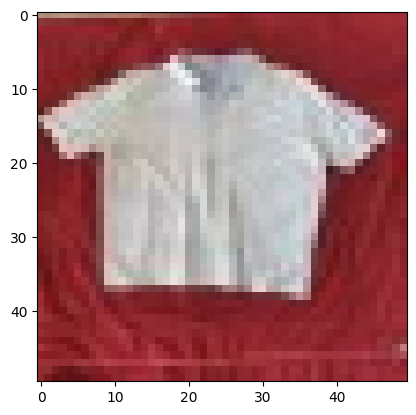

In [7]:
plt.imshow(preprocess_image(anchor_images[3]))

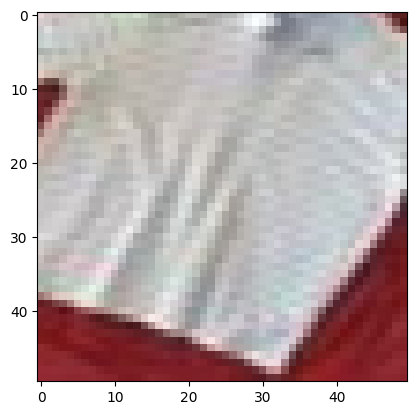

In [8]:
plt.imshow(preprocess_image(augmented_images[3]))

## Define training and validation sets

In [9]:
from progressbar import progressbar

anchor_images = [preprocess_image(f) for f in progressbar(anchor_images)]
augmented_images = [preprocess_image(f) for f in progressbar(augmented_images)]

100% (5308 of 5308) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (5308 of 5308) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


## Create pairs of images


In [10]:
def make_pairs(anchor_imgs, augmented_imgs, labels):
    num_classes = len(anchor_imgs)
    pairs = []
    labels = []

    for idx in range(num_classes):
        anchor = anchor_imgs[idx]
        augmented = augmented_imgs[idx]

        pairs += [[anchor, augmented]]
        labels += [0]

        # add a non-matching example
        idx_diff_pair = random.randint(0, num_classes - 1)
        while idx_diff_pair == idx:
            idx_diff_pair = random.randint(0, num_classes - 1)

        pairs += [[anchor, anchor_imgs[idx_diff_pair]]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

# make train pairs
classes = list(range(len(anchor_images)))
pairs, labels = make_pairs(anchor_images, augmented_images, classes)

In [11]:
# Keep 50% of train_val  in validation set
pairs_train, labels_train = pairs[:8000], labels[:8000]
pairs_val, labels_val = pairs[8000:10000], labels[8000:10000]
pairs_test, labels_test = pairs[10000:], labels[10000:]

We get:

**pairs_train.shape = (60000, 3, 50, 50)**

- We have 60,000 pairs
- Each pair contains 2 images
- Each image has shape `(50, 50)`

Split the training pairs

In [12]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the validation pairs

In [13]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

Split the test pairs

In [14]:
# x_test_1 = fst img in a pair
# x_test_2 = snd img in a pair
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

## Visualize pairs and their labels

In [15]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

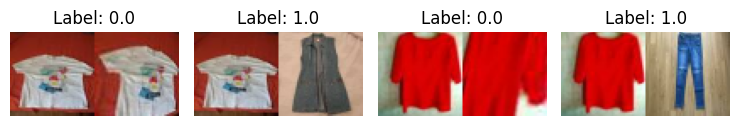

In [16]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect validation pairs

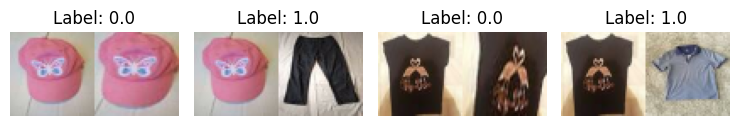

In [17]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

Inspect test pairs

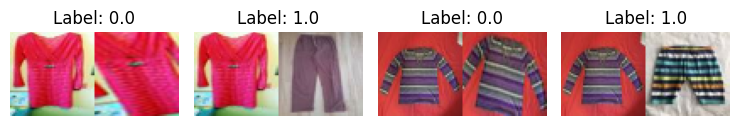

In [18]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [19]:
# With augmentation
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((50, 50, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(50, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((50, 50, 3))
input_1 = layers.RandomTranslation(0.2, 0.2)(input_1)
input_1 = layers.RandomZoom(0.2)(input_1)
input_1 = layers.RandomRotation(0.2)(input_1)
input_2 = layers.Input((50, 50, 3))
input_2 = layers.RandomTranslation(0.2, 0.2)(input_2)
input_2 = layers.RandomZoom(0.2)(input_2)
input_2 = layers.RandomRotation(0.2)(input_2)

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Define the constrastive Loss

In [21]:

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


## Compile the model with the contrastive loss

In [22]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           20086       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

## Train the model

In [23]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
500/500 [==============================] - 9s 8ms/step - loss: 0.1253 - accuracy: 0.8271 - val_loss: 0.0875 - val_accuracy: 0.8840
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1160 - accuracy: 0.8414 - val_loss: 0.0991 - val_accuracy: 0.8675
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1187 - accuracy: 0.8313 - val_loss: 0.0819 - val_accuracy: 0.8945
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 0.1159 - accuracy: 0.8385 - val_loss: 0.0836 - val_accuracy: 0.8865
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1147 - accuracy: 0.8432 - val_loss: 0.0999 - val_accuracy: 0.8595
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1119 - accuracy: 0.8471 - val_loss: 0.0875 - val_accuracy: 0.8700
Epoch 7/10
500/500 [==============================] - 4s 8ms/step - loss: 0.1182 - accuracy: 0.8347 - val_loss: 0.0818 - val_accuracy: 0.8845
Epoch 

## Visualize results

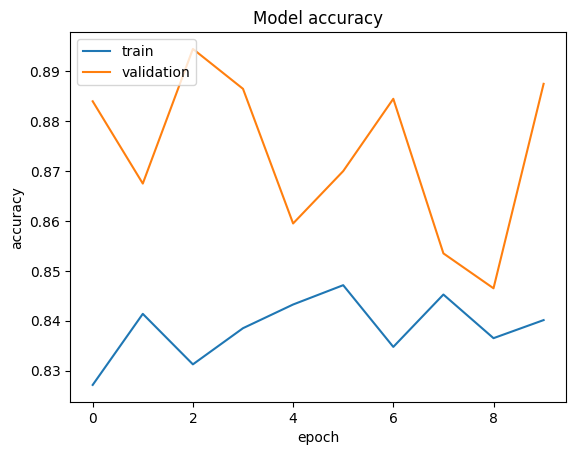

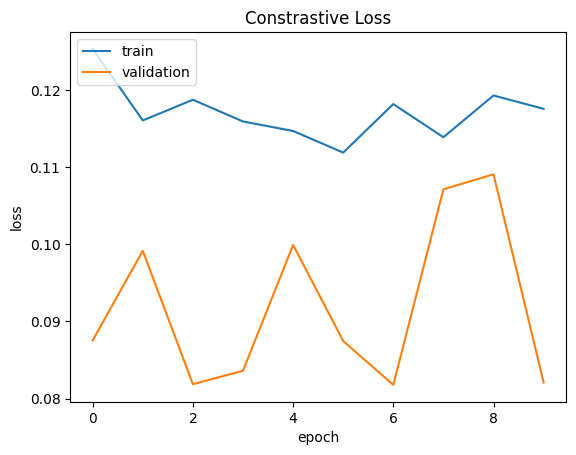

In [24]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

## Evaluate the model

In [25]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

20/20 [==============================] - 1s 9ms/step - loss: 0.0821 - accuracy: 0.8945
test loss, test acc: [0.08212105929851532, 0.8944805264472961]


## Visualize the predictions

20/20 [==============================] - 0s 3ms/step


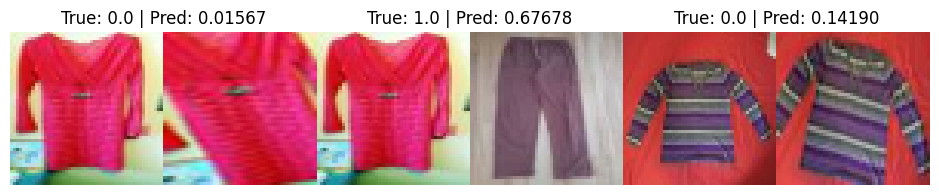

In [26]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Siamese%20Network-black.svg)](https://huggingface.co/keras-io/siamese-contrastive) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Siamese%20Network-black.svg)](https://huggingface.co/spaces/keras-io/siamese-contrastive) |

Testing with our imputs from the movies

1/1 [==============================] - 0s 125ms/step


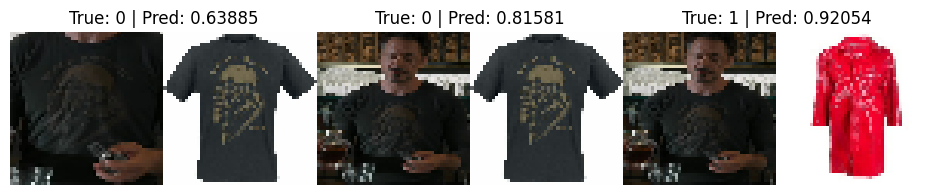

In [27]:
anchor = preprocess_image("avenger assemblee t shirt.jpg")
anchor_cropped = preprocess_image("Cropped.jpg")
product = preprocess_image("avengers assemblee tshirt product.jpg")
false = preprocess_image("big negative.jpg")

interest_pairs = np.array([[anchor_cropped, product], [anchor, product], [anchor, false]])

pred = siamese.predict([interest_pairs[:, 0], interest_pairs[:, 1]])
visualize(interest_pairs, labels=[0,0,1], to_show=1, predictions=pred, test=True)